In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)
import shared_utils

from calitp_data_analysis.tables import tbls
import calitp_data_analysis.magics

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt

import importlib
from rt_analysis import rt_filter_map_plot
import build_speedmaps_index

from IPython.display import display, Markdown, Latex, HTML, IFrame
import json
import base64

# Using module

In [2]:
import numpy as np

In [11]:
from rt_analysis import signal_tools
from shared_utils import rt_utils

In [30]:
from calitp_data_analysis import get_fs

In [31]:
import glob

In [12]:
import importlib
importlib.reload(signal_tools)

<module 'rt_analysis.signal_tools' from '/home/jovyan/data-analyses/rt_delay/rt_analysis/signal_tools.py'>

In [13]:
path = './signals_2023-06-12.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

# Spatial Arrays

## Read statewide segments (both lines and arrowized)

In [19]:
progress_df = pd.read_parquet('./_rt_progress_2023-07-12.parquet') >> filter(_.status == 'map_confirmed')

In [20]:
analysis_date = progress_df.analysis_date.iloc[0]

In [21]:
from tqdm.notebook import tqdm
pbar = tqdm()

0it [00:00, ?it/s]

In [54]:
def all_day_speedmap_segments(progress_df: pd.DataFrame = None,
                             itp_id_list: list = None,
                             analysis_date: dt.datetime = None,
                            # pbar: tqdm.notebook.tqdm = None):
                            pbar: tqdm = None):
    
    df_present = isinstance(progress_df, pd.DataFrame)
    assert df_present or itp_id_list and analysis_date, 'must provide either a speedmap progress df or itp_ids and analysis date'
    assert (not (df_present and itp_id_list))
                and (not (df_present and analysis_date)), 'must provide either a speedmap progress df or itp_ids and analysis date'
    itp_id_list = itp_id_list or progress_df.organization_itp_id.to_list()
    analysis_date = analysis_date or progress_df.analysis_date.iloc[0]
    all_segment_gdfs = []
    for itp_id in itp_id_list:
        print(itp_id)
        try:
            # all-day speeds (no filter)
            rt_day = rt_filter_map_plot.from_gcs(itp_id, analysis_date, pbar)
            _m = rt_day.segment_speed_map(how='low_speeds', no_title=True, shn=True,
                                 no_render=True
                                )

            dmv_proj = rt_day.detailed_map_view.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
            # re-add some identifiers since we won't have the instance handy
            dmv_proj['feed_key'] = rt_day.rt_trips.feed_key.iloc[0]
            dmv_proj['gtfs_dataset_key'] = rt_day.rt_trips.gtfs_dataset_key.iloc[0]
            dmv_proj['system_p50_median'] = dmv_proj.p50_mph.quantile(.5)

            all_segment_gdfs += [dmv_proj]
        except Exception as e:
            print(f'{itp_id}, {e}')
    
    all_segment_gdfs = pd.concat(all_segment_gdfs)
    return all_segment_gdfs

In [55]:
# all_segment_gdf = all_day_speedmap_segments(progress_df=progress_df, pbar=pbar)progress_df

In [36]:
# all_segment_gdf.to_parquet(f'segments_all_{analysis_date}.parquet')

In [46]:
# directly copy stop segment speed views
def copy_segment_speeds(progress_df: pd.DataFrame = None,
                        itp_id_list: list = None,
                        analysis_date: dt.datetime = None):
    
    df_present = isinstance(progress_df, pd.DataFrame)
    assert df_present or itp_id_list and analysis_date, 'must provide either a speedmap progress df or itp_ids and analysis date'
    assert (not (df_present and itp_id_list))
                and (not (df_present and analysis_date)), 'must provide either a speedmap progress df or itp_ids and analysis date'
    itp_id_list = itp_id_list or progress_df.organization_itp_id.to_list()
    analysis_date = analysis_date or progress_df.analysis_date.iloc[0]
    fs = get_fs()
    base = 'gs://calitp-analytics-data/data-analyses/rt_delay/v2_segment_speed_views/'
    pattern = f'_{analysis_date}_All_Day.parquet'
    patterns = [str(itp_id) + pattern for itp_id in itp_id_list]
    remote_paths = [base + pattern for pattern in patterns]
    local_path = f'./segment_lines_all_{analysis_date}'
    os.system(f'mkdir {local_path}')
    fs.get(remote_paths, f'{local_path}/')
    
    # https://gis.stackexchange.com/questions/394391/reading-all-shapefiles-in-folder-using-geopandas-and-then-clipping-them-all-iter
    files = glob.iglob(f'{local_path}/*')
    gdfs = (gpd.read_parquet(file) for file in files) # generator
    segment_lines_all = pd.concat(gdfs)
    
    os.system(f'rm -rf {local_path}')
    
    return segment_lines_all

In [47]:
segment_lines_all = copy_segment_speeds(progress_df)

mkdir: cannot create directory ‘./segment_lines_all_2023-07-12’: File exists


In [65]:
segment_lines_all.to_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [51]:
segments_all = gpd.read_parquet(f'segments_all_{analysis_date}.parquet')

In [64]:
segment_lines_all = gpd.read_parquet(f'./segment_lines_all_{analysis_date}.parquet')

## Prep statewide signals, joins

In [ ]:
def sjoin_signals(signal_gdf, segments_gdf, segments_lines_gdf):
    
    # read in, seperate points geo, spatial join to statewide segments

    signals = (signal_gdf
                   >> filter(_.tms_unit_type != 'Freeway Ramp Meters')
                   >> select(_.imms_id, _.location, _.geometry)
               ).copy()
    signals_points = signals.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
    signals_buffered = signals_points.copy()
    signals_buffered.geometry = signals_buffered.buffer(150)

    joined = gpd.sjoin(segments_all, signals_buffered) >> select(-_.index_right)

    points_for_join = signals_points >> select(_.imms_id, _.signal_pt_geom == _.geometry)
    joined_signal_points = joined >> inner_join(_, points_for_join, on ='imms_id')

    # add line geometries from stop_segment_speed_view
    seg_lines = (segment_lines_all
                >> select(_.line_geom == _.geometry, _.shape_id, _.stop_sequence, _.stop_id)
                >> distinct(_.line_geom, _.shape_id, _.stop_sequence, _.stop_id)
            )
    # ideally a more robust join in the future
    joined_seg_lines = joined_signal_points >> inner_join(_, seg_lines, on = ['shape_id', 'stop_sequence', 'stop_id'])

In [53]:
# # read in, seperate points geo, spatial join to statewide segments

# signals = (signal_gdf
#                >> filter(_.tms_unit_type != 'Freeway Ramp Meters')
#                >> select(_.imms_id, _.location, _.geometry)
#            ).copy()
# signals_points = signals.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
# signals_buffered = signals_points.copy()
# signals_buffered.geometry = signals_buffered.buffer(150)

# joined = gpd.sjoin(segments_all, signals_buffered) >> select(-_.index_right)

# points_for_join = signals_points >> select(_.imms_id, _.signal_pt_geom == _.geometry)
# joined_signal_points = joined >> inner_join(_, points_for_join, on ='imms_id')

In [68]:
# # add line geometries from stop_segment_speed_view
# seg_lines = (segment_lines_all
#             >> select(_.line_geom == _.geometry, _.shape_id, _.stop_sequence, _.stop_id)
#             >> distinct(_.line_geom, _.shape_id, _.stop_sequence, _.stop_id)
#         )
# # ideally a more robust join in the future
# joined_seg_lines = joined_signal_points >> inner_join(_, seg_lines, on = ['shape_id', 'stop_sequence', 'stop_id'])

In [69]:
import shapely

In [70]:
@np.vectorize
def vector_start(linestring):
    return shapely.ops.substring(linestring, 0, 0)

@np.vectorize
def vector_end(linestring):
    return shapely.ops.substring(linestring, linestring.length, linestring.length)

start_array = vector_start(joined_seg_lines.line_geom)
end_array = vector_end(joined_seg_lines.line_geom)

@np.vectorize
def vector_distance(point1, point2):
    return point1.distance(point2)

In [71]:
start_distances = vector_distance(start_array, joined_seg_lines.signal_pt_geom)
end_distances = vector_distance(end_array, joined_seg_lines.signal_pt_geom)

approaching = start_distances > end_distances
# approaching

In [72]:
assert len(approaching) == len(joined_seg_lines)

In [73]:
joined_seg_lines['approaching'] = approaching

In [74]:
len(approaching)

66240

## Calculate metrics

In [75]:
to_calculate = (joined_seg_lines
          >> filter(_.p50_mph < 20) # filter out fast segments
          >> filter(_.approaching)
          >> select(-_.signal_pt_geom, -_.line_geom)
      )

In [76]:
to_calculate.columns

Index(['stop_id', 'stop_name', 'geometry', 'shape_id', 'stop_sequence',
       'route_id', 'route_short_name', 'direction_id', 'p50_mph', 'p20_mph',
       'p80_mph', 'fast_slow_ratio', 'trips_per_hour', 'miles_from_last',
       'time_formatted', 'feed_key', 'gtfs_dataset_key', 'system_p50_median',
       'imms_id', 'location', 'approaching'],
      dtype='object')

In [77]:
def calculate_speed_score(df):
    twenty_mph = 20
    decile_raw = ((df.p50_mph - df.system_p50_median) / df.system_p50_median) * 10
    decile_raw_20 = ((df.p50_mph - twenty_mph) / twenty_mph) * 10
    decile_min = np.minimum(decile_raw, decile_raw_20)
    decile_rounded = np.round(decile_min, 0).astype('int64')
    # positive values are comparatively higher speeds, mask to 0 to indicate low priority
    decile_masked = decile_rounded.mask(decile_rounded > 0, 0)
    decile_score = np.absolute(decile_masked)
    df['speed_score'] = decile_score
    return df

In [78]:
def calculate_variability_score(df):
    variability = df.fast_slow_ratio
    variability_low_mask = variability.mask(variability <= 1, 0)
    variability_scaled = np.round(variability * 3, 0)
    variability_high_mask = variability_scaled.mask(variability_scaled > 10, 10)
    variability_score = variability_high_mask.astype('int64')
    df['variability_score'] = variability_score
    return df

In [79]:
def calculate_frequency_score(df):
    frequency = df.trips_per_hour
    frequency_scaled = np.round(frequency * 2, 0)
    frequency_score = frequency_scaled.mask(frequency_scaled > 10, 10).astype('int64')
    df['frequency_score'] = frequency_score
    return df

In [80]:
to_calculate = calculate_speed_score(to_calculate)
to_calculate = calculate_variability_score(to_calculate)
to_calculate = calculate_frequency_score(to_calculate)
to_calculate['transit_score'] = to_calculate.speed_score + to_calculate.variability_score + to_calculate.frequency_score

In [93]:
median_by_signal = to_calculate >> group_by(_.imms_id, _.location) >> summarize(speed_score = _.speed_score.median(),
                                            variability_score = _.variability_score.median(),
                                            frequency_score = _.frequency_score.median(),
                                            overall_transit_score = _.transit_score.median(),
                                           )

In [94]:
median_by_signal >> arrange(-_.overall_transit_score)

,imms_id,location,speed_score,variability_score,frequency_score,overall_transit_score
955,04SM082 -E35I6,BALDWIN AVE/BAYWOOD AVE and EL CAMINO REAL (RT...,7.0,8.0,10.0,25.0
200,04ALA013 - EZ132,COLLEGE AVE and ASHBY AVE (RTE 13),6.0,8.5,10.0,24.5
569,04NAP029 -E21C5,WASHINGTON ST and LINCOLN AVE (RTE 29),7.5,7.0,10.0,24.5
201,04ALA013 - EZ133,COLBY ST and ASHBY AVE (RTE 13),4.0,10.0,10.0,24.0
568,04NAP029 -E21B9,ADAMS ST and MAIN ST (RTE 29/128),6.5,7.5,10.0,24.0
...,...,...,...,...,...,...
1515,07LA001 -ED160,BLUFF CREEK,1.0,3.0,0.0,4.0
2040,07LA405 -ED537,SB HOWARD HUGHES PKWY,1.0,3.0,0.0,4.0
2535,11SD094 -E8005,DAISY DR,0.0,4.0,0.0,4.0
1732,07LA101 -E0400,101 FWY SB MISSION -ALISO,0.0,3.0,0.0,3.0


## Reference Histograms for subscores

<AxesSubplot:>

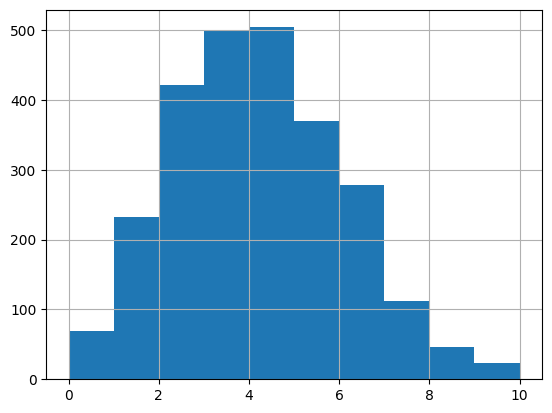

In [95]:
median_by_signal.speed_score.hist()

<AxesSubplot:>

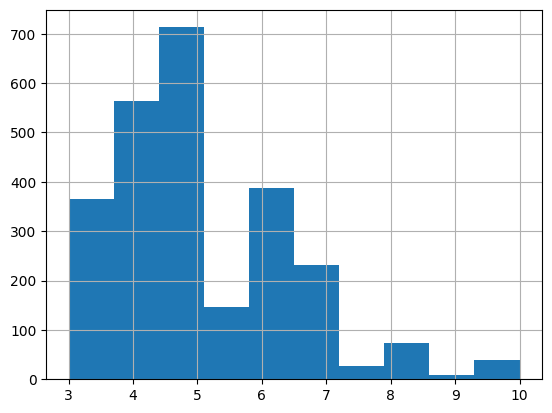

In [96]:
median_by_signal.variability_score.hist()

<AxesSubplot:>

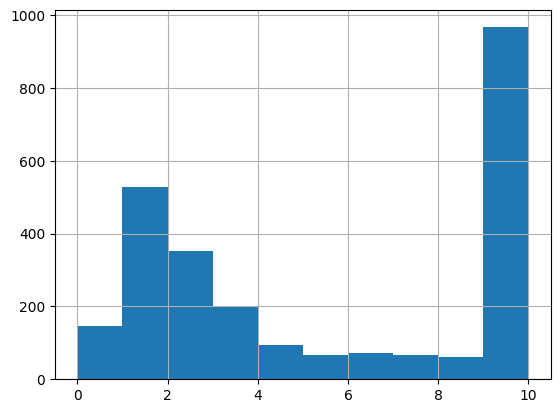

In [97]:
median_by_signal.frequency_score.hist()

<AxesSubplot:>

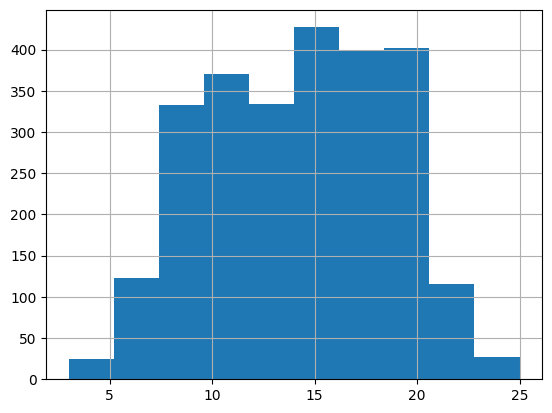

In [98]:
median_by_signal.overall_transit_score.hist()

In [213]:
test = df >> arrange(-_.combined_score) >> head(15)

In [214]:
rt_utils.set_state_export(test,
                          filename='signal_join_test1', cache_seconds=0,
                          cmap=rt_utils.ZERO_THIRTY_COLORSCALE, color_col='p20_mph',
                          legend_url=rt_utils.SPEEDMAP_LEGEND_URL
                    )

writing to calitp-map-tiles/testing/signal_join_test1.geojson.gz


{'state_dict': {'name': 'null',
  'layers': [{'name': 'Map',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/testing/signal_join_test1.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}],
  'lat_lon': (34.02889742320673, -118.44357591292896),
  'zoom': 13,
  'legend_url': 'https://storage.googleapis.com/calitp-map-tiles/speeds_legend.svg'},
 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJNYXAiLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3Rlc3Rpbmcvc2lnbmFsX2pvaW5fdGVzdDEuZ2VvanNvbi5neiIsICJwcm9wZXJ0aWVzIjogeyJzdHJva2VkIjogZmFsc2UsICJoaWdobGlnaHRfc2F0dXJhdGlvbl9tdWx0aXBsaWVyIjogMC41fX1dLCAibGF0X2xvbiI6IFszNC4wMjg4OTc0MjMyMDY3MywgLTExOC40NDM1NzU5MTI5Mjg5Nl0sICJ6b29tIjogMTMsICJsZWdlbmRfdXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3NwZWVkc19sZWdlbmQuc3ZnIn0='}

# Score everything!

In [223]:
progress_df >> head(3)

,organization_name,organization_itp_id,organization_source_record_id,caltrans_district,_is_current,analysis_date,status
0,Cloverdale Transit,70,recRM3c9Zfaft4V2B,04 - Oakland,False,2023-07-12,map_confirmed
1,Sonoma County,314,recDupUxInMUgxeiz,04 - Oakland,False,2023-07-12,map_confirmed
2,Nevada County,221,reczUcQgqgtMpkpKC,03 - Marysville,True,2023-07-12,map_confirmed


In [233]:
path = './signals_2023-06-12.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

all_metric_gdfs = []
for itp_id in progress_df.organization_itp_id:
# for itp_id in [350, 4]:
    print(itp_id)
    try:
        # all-day speeds (no filter)
        rt_day = rt_filter_map_plot.from_gcs(itp_id, progress_df.analysis_date.iloc[0])
        signal_tools.generate_speedmap_buffer_signals(rt_day, signal_gdf)
        signal_tools.calculate_signal_metric(rt_day)
        
        all_metric_gdfs += [rt_day.signals_metrics]
    except Exception as e:
        print(f'{itp_id}, {e}')

70
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_70_2023-07-12.parquet
.signals attribute added
.signals_metrics attribute added
314
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_314_2023-07-12.parquet
.signals attribute added
.signals_metrics attribute added
221
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_221_2023-07-12.parquet
stop_speeds shape: (0, 17), shape_id: p_857973
stop speeds gdf is empty!
stop_speeds shape: (0, 17), shape_id: p_1277435
stop speeds gdf is empty!
.signals attribute added
.signals_metrics attribute added
350
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_350_2023-07-12.parquet
.signals attribute added
.signals_metrics attribute added
105
found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_105_2023-07-12.parquet
.si

In [238]:
gdf_all = pd.concat(all_metric_gdfs)
gdf_all.to_parquet('./_signal_metrics_gdf.parquet')

In [239]:
df_all = gdf_all >> group_by(_.imms_id) >> summarize(speed_score = _.speed_score.median(),
                                            variability_score = _.variability_score.median(),
                                            frequency_score = _.frequency_score.median(),
                                            overall_transit_score = _.combined_score.median(),
                                           )
df_all.to_parquet('./_signal_metrics_df.parquet')

In [242]:
df_all = df_all.rename(columns={'imms_id': "IMMS ID"})

In [244]:
original_format = pd.read_excel('./signals_2023-06-12.xlsx') >> inner_join(_, df_all, on = ['IMMS ID'])

In [245]:
original_format.to_excel('transit_score_signals_2023-06-12.xlsx')